In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import os
import glob as glob
from zipfile import ZipFile
from urllib.request import urlretrieve

import warnings
import logging
import absl
warnings.filterwarnings('ignore', module='absl')
logging.captureWarnings(True)
absl_logger = logging.getLogger('absl')
absl_logger.setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1. Download Sample Images

In [2]:
def download_and_unzip(url, save_path):

    # downloading zip file using urllib package
    urlretrieve(url, save_path)

    # extracting zip file using the zipfile package
    with ZipFile(save_path) as z:

        # extract ZIP file contents in the same directory
        z.extractall(os.path.split(save_path)[0])

In [3]:
URL = r'https://www.dropbox.com/s/h7l1lmhvga6miyo/object_detection_images.zip?dl=1'

curr_dir = os.getcwd()
save_path = os.path.join(curr_dir, 'object_detection_images.zip')

download_and_unzip(URL, save_path)

In [4]:
image_paths = sorted(glob.glob('object_detection_images' + '/*png'))

print('number of sample images:', len(image_paths))

number of sample images: 4


## 1.1 Display the Images

In [5]:
def load_image(path):
  image = cv2.imread(path)

  # convert image in BGR format to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # add a batch dimension which is required by the model
  image = np.expand_dims(image, axis=0)

  return image

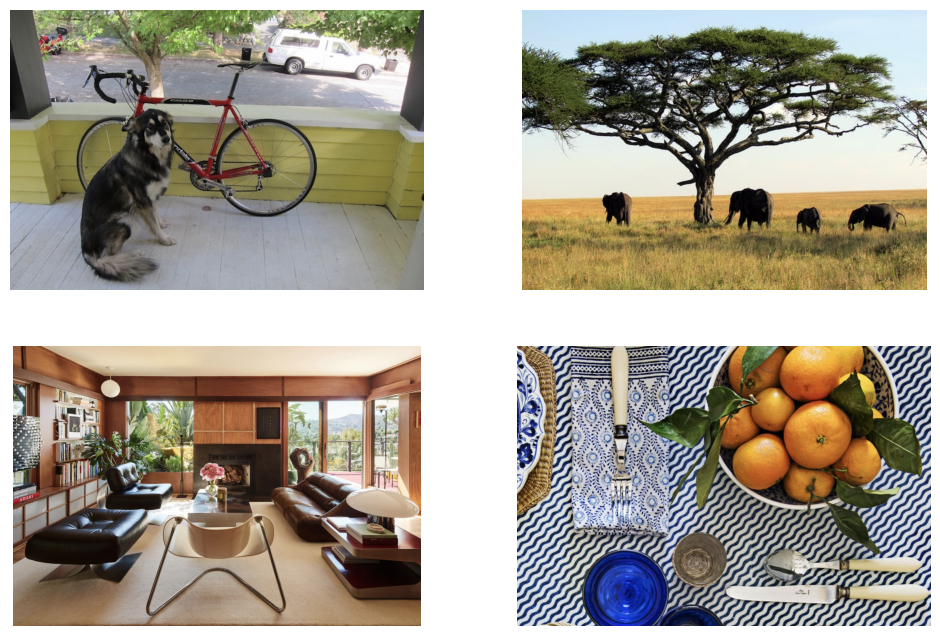

In [6]:
# store the image arrays
images = []

# plot
plt.figure(figsize=(12, 8))
for i, image_path in enumerate(image_paths):
  ax = plt.subplot(2, 2, i + 1)
  image = load_image(image_path)
  images.append(image)
  plt.imshow(image[0])
  plt.axis('off');

## 1.2 Define a Dictionary that Maps Class IDs to Class Names

In [7]:
class_index =  \
{
         1: 'person',
         2: 'bicycle',
         3: 'car',
         4: 'motorcycle',
         5: 'airplane',
         6: 'bus',
         7: 'train',
         8: 'truck',
         9: 'boat',
         10: 'traffic light',
         11: 'fire hydrant',
         13: 'stop sign',
         14: 'parking meter',
         15: 'bench',
         16: 'bird',
         17: 'cat',
         18: 'dog',
         19: 'horse',
         20: 'sheep',
         21: 'cow',
         22: 'elephant',
         23: 'bear',
         24: 'zebra',
         25: 'giraffe',
         27: 'backpack',
         28: 'umbrella',
         31: 'handbag',
         32: 'tie',
         33: 'suitcase',
         34: 'frisbee',
         35: 'skis',
         36: 'snowboard',
         37: 'sports ball',
         38: 'kite',
         39: 'baseball bat',
         40: 'baseball glove',
         41: 'skateboard',
         42: 'surfboard',
         43: 'tennis racket',
         44: 'bottle',
         46: 'wine glass',
         47: 'cup',
         48: 'fork',
         49: 'knife',
         50: 'spoon',
         51: 'bowl',
         52: 'banana',
         53: 'apple',
         54: 'sandwich',
         55: 'orange',
         56: 'broccoli',
         57: 'carrot',
         58: 'hot dog',
         59: 'pizza',
         60: 'donut',
         61: 'cake',
         62: 'chair',
         63: 'couch',
         64: 'potted plant',
         65: 'bed',
         67: 'dining table',
         70: 'toilet',
         72: 'tv',
         73: 'laptop',
         74: 'mouse',
         75: 'remote',
         76: 'keyboard',
         77: 'cell phone',
         78: 'microwave',
         79: 'oven',
         80: 'toaster',
         81: 'sink',
         82: 'refrigerator',
         84: 'book',
         85: 'clock',
         86: 'vase',
         87: 'scissors',
         88: 'teddy bear',
         89: 'hair drier',
         90: 'toothbrush'
}

Here we will use `COLOR_IDS` to map each class with a unique RGB color.

In [8]:
R = np.array(np.arange(96, 256, 32))
G = np.roll(R, 1)
B = np.roll(R, 2)

COLOR_IDS = np.array(np.meshgrid(R, G, B)).T.reshape(-1, 3)

# 2. Load the Model

Here we will use the `EfficientDet` class of object detection models that were trained on the [COCO 2017 dataset](https://cocodataset.org/#home).

There are several versions of EfficientDet models. The EfficientDet family of object detectors consists of several models with different levels of complexity and performance, ranging from D0 to D7.

The differences between the various models in the EfficientDet family are mainly in their architecture, input image size, computational requirements, and performance.

In [9]:
EfficientDet  = {'EfficientDet D0 512x512'   : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
                 'EfficientDet D1 640x640'   : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
                 'EfficientDet D2 768x768'   : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
                 'EfficientDet D3 896x896'   : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
                 'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
                 'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
                 'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
                 'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1'
                }

Here we will use the D4 model.

In [10]:
model_url = EfficientDet['EfficientDet D4 1024x1024' ]
od_model = hub.load(model_url)

# 3 Generate Results

## 3.1 Perform Inference

Return the detection result.

In [11]:
def run_inference(image, model):

  # call the model.
  # get the detection results in the form of a dictionary
  result = model(image)

  # convert the dictionary values to numpy arrays
  result = {key:value.numpy() for key, value in result.items()}

  return result

## 3.2 Post-Process Detections

In [12]:
def process_detection(image, result, min_det_thresh=.3):

  # remove the batch dimension from the image
  image = np.squeeze(image)

  # extract the detection results from the results dictionary
  scores  =  result['detection_scores'][0]
  boxes   =  result['detection_boxes'][0]
  classes = (result['detection_classes'][0]).astype(int)

  # get the detections whose scores exceed the minimum detection threshold
  det_indices = np.where(scores >= min_det_thresh)[0]

  scores_thresh  = scores[det_indices]
  boxes_thresh   = boxes[det_indices]
  classes_thresh = classes[det_indices]

  # make a copy of the image to annotate
  img_bbox = image.copy()

  im_height, im_width = image.shape[:2]

  font_scale = .6
  box_thickness = 2

  # loop over all thresholded detections
  for box, class_id, score in zip(boxes_thresh, classes_thresh, scores_thresh):

      # get bounding box normalized coordiantes
      ymin, xmin, ymax, xmax = box

      class_name = class_index[class_id]

      # convert normalized bounding box coordinates to pixel coordinates
      (left, right, top, bottom) = (int(xmin * im_width),
                                    int(xmax * im_width),
                                    int(ymin * im_height),
                                    int(ymax * im_height))

      # annotate the image with the bounding box
      color = tuple(COLOR_IDS[class_id % len(COLOR_IDS)].tolist())[::-1]
      img_bbox = cv2.rectangle(img_bbox, (left, top), (right, bottom), color, thickness=box_thickness)

      #-------------------------------------------------------------------
      # Annotate bounding box with detection data (class name and score)
      #-------------------------------------------------------------------

      # build the text string that contains the class name and score associated with this detection
      display_txt = '{}: {:.2f}%'.format(class_name, 100 * score)
      ((text_width, text_height), _) = cv2.getTextSize(display_txt, cv2.FONT_HERSHEY_SIMPLEX, font_scale, 1)

      # handle case when the label is above the image frame
      if top < text_height:
          shift_down = int(2*(1.3*text_height))
      else:
          shift_down = 0

      # draw a filled rectangle on which the detection results will be displayed.
      img_bbox = cv2.rectangle(img_bbox,
                              (left-1, top-box_thickness - int(1.3*text_height) + shift_down),
                              (left-1 + int(1.1 * text_width), top),
                              color,
                              thickness=-1)

      # annotate the filled rectangle with text (class label and score).
      img_bbox = cv2.putText(img_bbox,
                            display_txt,
                            (left + int(.05*text_width), top - int(0.2*text_height) + int(shift_down/2)),
                            cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), 1)

  return img_bbox

## 3.3 Display the Detections

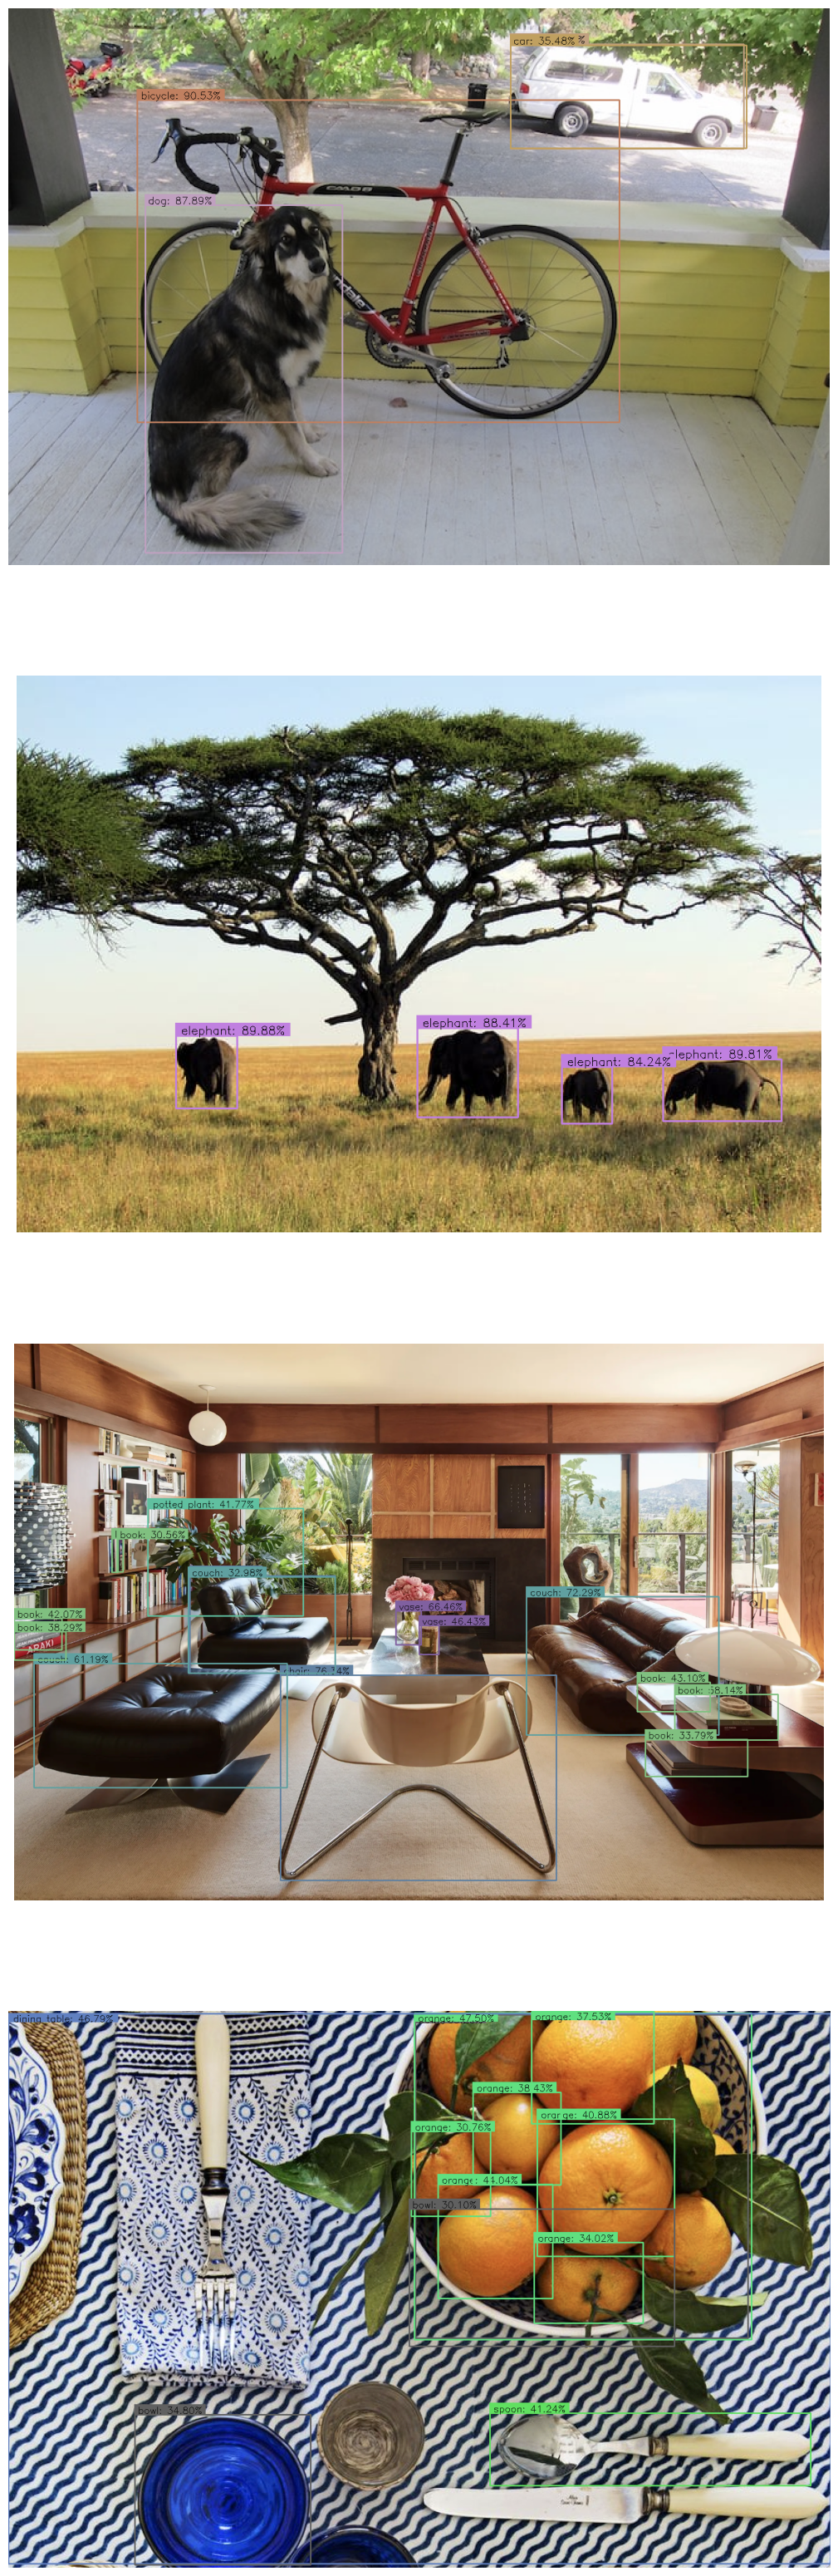

In [13]:
plt.figure(figsize=[20, 40])
for i, image in enumerate(images):
  result = run_inference(image, od_model)
  img_bbox = process_detection(image, result, min_det_thresh=0.3)
  ax = plt.subplot(4, 1, i + 1)
  plt.imshow(img_bbox)
  plt.axis('off');